In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import matplotlib.pyplot as plt
import multielec_src.fitting as fitting
import multielec_src.multielec_utils as mutils
from scipy.io import loadmat
import multiprocessing as mp
import statsmodels.api as sm
from copy import deepcopy, copy
import visionloader as vl

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    p_empirical_array = np.array(p_empirical)

    return p_empirical_array

In [3]:
def sample_spikes_array(true_probs, trials, NUM_THREADS=24):

    input_list = []
    for i in range(len(true_probs)):
        for j in range(len(true_probs[i])):
            input_list += [(true_probs[i][j], trials[j])]
            
    pool = mp.Pool(processes=NUM_THREADS)
    results = pool.starmap_async(sample_spikes, input_list)
    mp_output = results.get()
    pool.close()

    return np.array(mp_output).reshape(true_probs.shape)
    

In [4]:
def get_performance_array(true_params, curr_probs, true_probs):
    
    error = 0
    cnt = 0
    for i in range(len(true_params)):
        for j in range(len(true_params[i])):
            if ~np.all(true_params[i][j][:, 0] == -np.inf):
                error += np.sqrt(np.sum((curr_probs[i][j] - true_probs[i][j])**2) / len(true_probs[i][j]))
                cnt += 1

    return error / cnt

# Old labview

In [5]:
Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [6]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-18-5"
wnoise = "kilosort_data002/data002"
blanked_probs = 12
spont_limit = 0.25
min_inds = 3

estim_neg = "data001"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([-Ivals.reshape(-1, 1)] * len(trials_neg))

# Processing data below: do other stuff if your pipeline is different
all_probs_neg[:, :, :blanked_probs] = 0

clean_inds_array = np.full((all_probs_neg.shape[0], all_probs_neg.shape[1]), 
                            None, dtype=object)

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if np.count_nonzero(all_probs_neg[i][j] >= spont_limit) >= min_inds:
            print(cells[i], j+1)

            clean_inds = np.where(~np.isnan(all_probs_neg[i][j]))[0]
            clean_inds_array[i][j] = clean_inds

            
            all_probs_neg[i][j][clean_inds] = fitting.disambiguate_sigmoid(all_probs_neg[i][j][clean_inds],
                                                                            spont_limit=spont_limit, noise_limit=0.1)

16 36
16 45
17 22
17 31
17 40
17 431
27 52
42 61
42 65
42 69
42 74
42 83
44 61
57 88
57 91
57 97
57 455
57 465
57 467
57 475
116 100
116 118
116 123
116 126
116 129
120 114
120 119
131 142
131 143
131 144
131 455
131 465
134 147
134 337
134 350
144 165
144 174
144 175
144 378
154 190
154 234
154 337
154 350
154 358
154 367
154 373
154 394
168 217
168 218
168 226
168 227
168 228
168 385
171 225
171 235
174 229
177 309
177 373
177 394
216 268
216 277
216 283
216 370
216 379
220 261
220 263
220 264
220 266
220 270
220 279
220 288
221 271
221 280
221 289
268 280
268 289
299 295
319 234
319 301
319 337
319 364
319 372
410 337
410 349
410 350
410 358
410 359
410 367
410 368
410 375
410 376
414 343
414 347
414 352
415 361
434 363
454 358
454 367
490 373
674 442
680 430
680 438
680 451
687 469
687 470
687 478
687 479
687 488
697 509
744 490


In [7]:
ms = [1]

w_inits_array = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [8]:
input_list = fitting.generate_input_list(all_probs_neg, amps_neg, trials_neg, w_inits_array,
                                         pass_inds=clean_inds_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [9]:
params_true = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
inits = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
R2s = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]))
probs_true = np.zeros(all_probs_neg.shape)

cnt = 0
for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        R2s[i][j] = mp_output[cnt][2]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_true[i][j])
        

        cnt += 1

[[-8.36462318 -6.52885417]] 0.8099738539170163


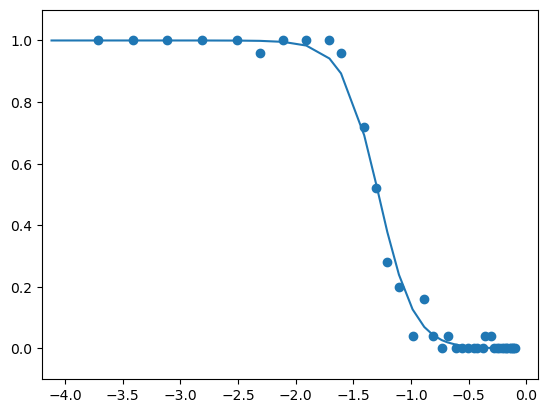

KeyboardInterrupt: Interrupted by user

In [10]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(params_true[i][j], R2s[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j].flatten(), all_probs_neg[i][j])
            plt.plot(amps_neg[j].flatten(), probs_true[i][j])
            plt.show()
            input()

In [11]:
EI_cutoff = 0

vstim_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vstim_datarun = wnoise[-7:]
vcd = vl.load_vision_data(vstim_datapath, vstim_datarun,
                          include_neurons=True,
                          include_ei=True,
                          include_params=True,
                          include_noise=True)

above_thr_inds = []
for n in vcd.get_cell_ids():
    cell_type = vcd.get_cell_type_for_cell(n).lower()
    if 'parasol' in cell_type or 'midget' in cell_type:
        _, EI = mutils.get_collapsed_ei_thr(vcd, n, 0)
        above_thr = np.where(EI > EI_cutoff)[0]
        if len(above_thr) > 0:
            above_thr_inds.append(above_thr)

above_thr_all = np.unique(np.concatenate(above_thr_inds))
bad_inds = np.setdiff1d(np.arange(len(trials_neg), dtype=int), above_thr_all).astype(int)

Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(41488.023, dtype=float32), DeviceArray(18855.207, dtype=float32), DeviceArray(60545.82, dtype=float32), DeviceArray(19057.795, dtype=float32))
1
(DeviceArray(40078.438, dtype=float32), DeviceArray(16988.578, dtype=float32), DeviceArray(55118.953, dtype=float32), DeviceArray(15040.517, dtype=float32))
2
(DeviceArray(38795.965, dtype=float32), DeviceArray(15120.316, dtype=float32), DeviceArray(49815.688, dtype=float32), DeviceArray(11019.724, dtype=float32))
3
(DeviceArray(37625.58, dtype=float32), DeviceArray(13250.16, dtype=float32), DeviceArray(44620.434, dtype=float32), DeviceArray(6994.8545, dtype=float32))
4
(DeviceArray(36554.973, dtype=float32), DeviceArray(11377.904, dtype=float32), DeviceArray(39520.438, dtype=float32), DeviceArray(2965.466, dtype=float32))
5
(DeviceArray(35573.22, dtype=float32), DeviceArray(9503.559, dtype=float32), DeviceArray(36641.637, dtype=float32), DeviceAr

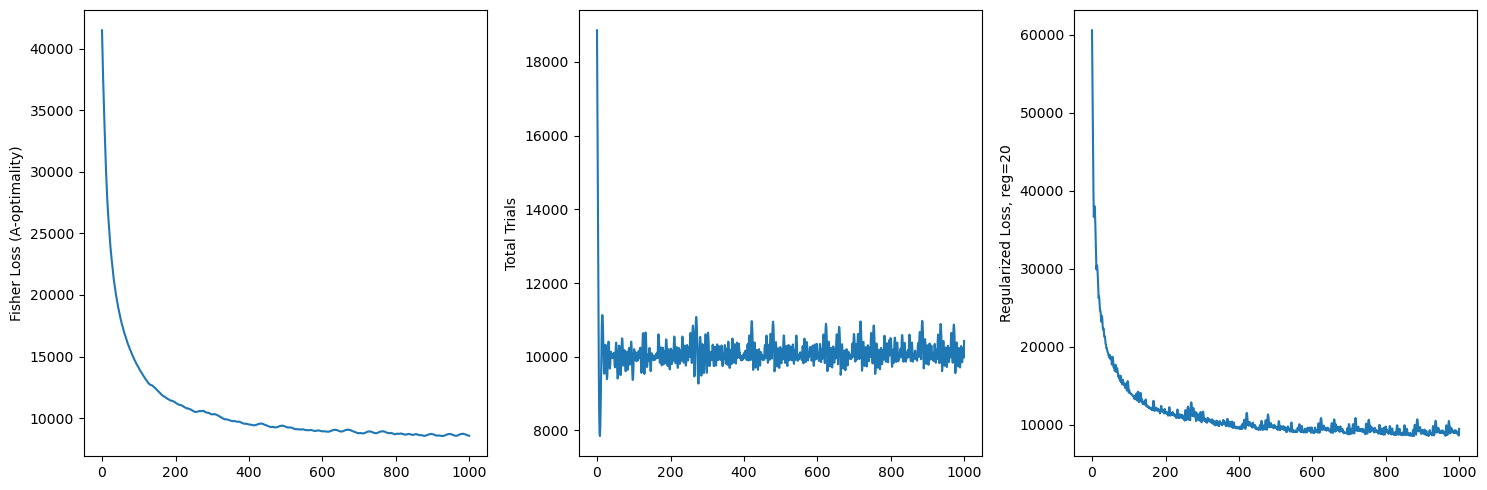

0.05139792792733778 0.05139792792733778


/tmp/ipykernel_27256/902474025.py:98: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
/tmp/ipykernel_27256/902474025.py:111: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(5270.255, dtype=float32), DeviceArray(10928.948, dtype=float32), DeviceArray(5515.077, dtype=float32), DeviceArray(244.82239, dtype=float32))
1
(DeviceArray(5268.848, dtype=float32), DeviceArray(10698.807, dtype=float32), DeviceArray(5453.017, dtype=float32), DeviceArray(184.16904, dtype=float32))
2
(DeviceArray(5265.3496, dtype=float32), DeviceArray(9918.963, dtype=float32), DeviceArray(5286.7065, dtype=float32), DeviceArray(21.357162, dtype=float32))
3
(DeviceArray(5241.0557, dtype=float32), DeviceArray(10064.845, dtype=float32), DeviceArray(5258.1455, dtype=float32), DeviceArray(17.089693, dtype=float32))
4
(DeviceArray(5221.8003, dtype=float32), DeviceArray(9713.103, dtype=float32), DeviceArray(5297.4116, dtype=float32), DeviceArray(75.61123, dtype=float32))
5
(DeviceArray(5196.3135, dtype=float32), DeviceArray(9899.242, dtype=float32), DeviceArray(5222.868, dtype=float32), DeviceArray

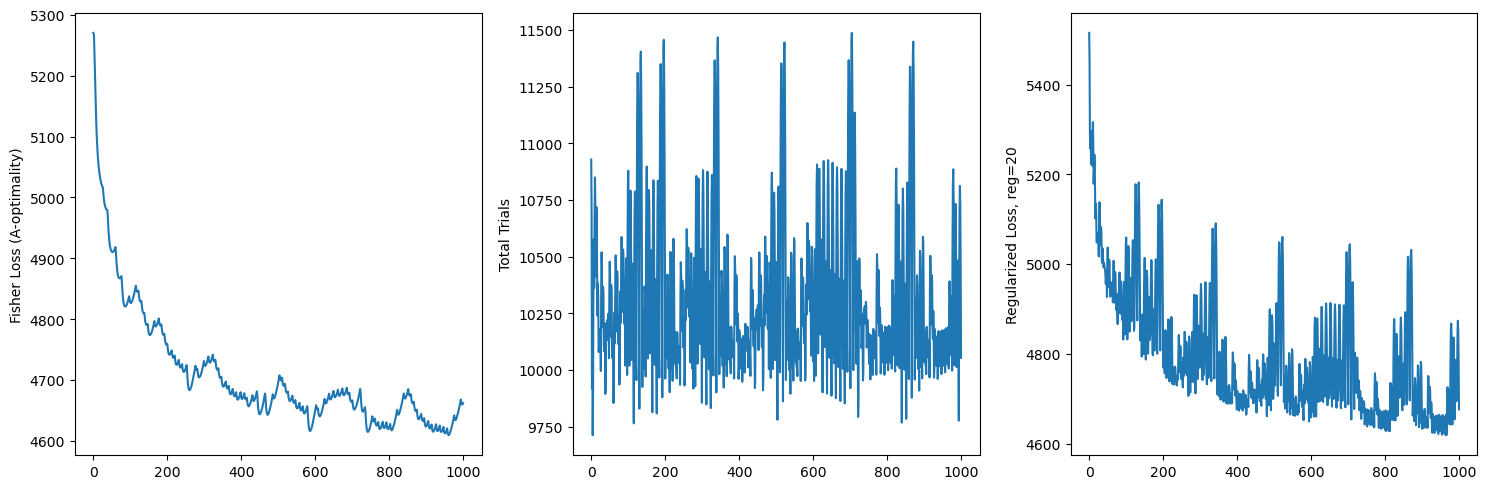

0.01963883802965369 0.04122726265914675


/tmp/ipykernel_27256/902474025.py:98: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
/tmp/ipykernel_27256/902474025.py:111: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(3277.0283, dtype=float32), DeviceArray(11288.835, dtype=float32), DeviceArray(3487.8748, dtype=float32), DeviceArray(210.84639, dtype=float32))
1
(DeviceArray(3283.3125, dtype=float32), DeviceArray(11127.139, dtype=float32), DeviceArray(3467.7063, dtype=float32), DeviceArray(184.39375, dtype=float32))
2
(DeviceArray(3290.9844, dtype=float32), DeviceArray(10278.139, dtype=float32), DeviceArray(3336.4863, dtype=float32), DeviceArray(45.501972, dtype=float32))
3
(DeviceArray(3297.8389, dtype=float32), DeviceArray(9857.16, dtype=float32), DeviceArray(3321.2068, dtype=float32), DeviceArray(23.36782, dtype=float32))
4
(DeviceArray(3291.9766, dtype=float32), DeviceArray(11228.283, dtype=float32), DeviceArray(3492.917, dtype=float32), DeviceArray(200.94044, dtype=float32))
5
(DeviceArray(3288.9048, dtype=float32), DeviceArray(11880.32, dtype=float32), DeviceArray(3596.515, dtype=float32), DeviceAr

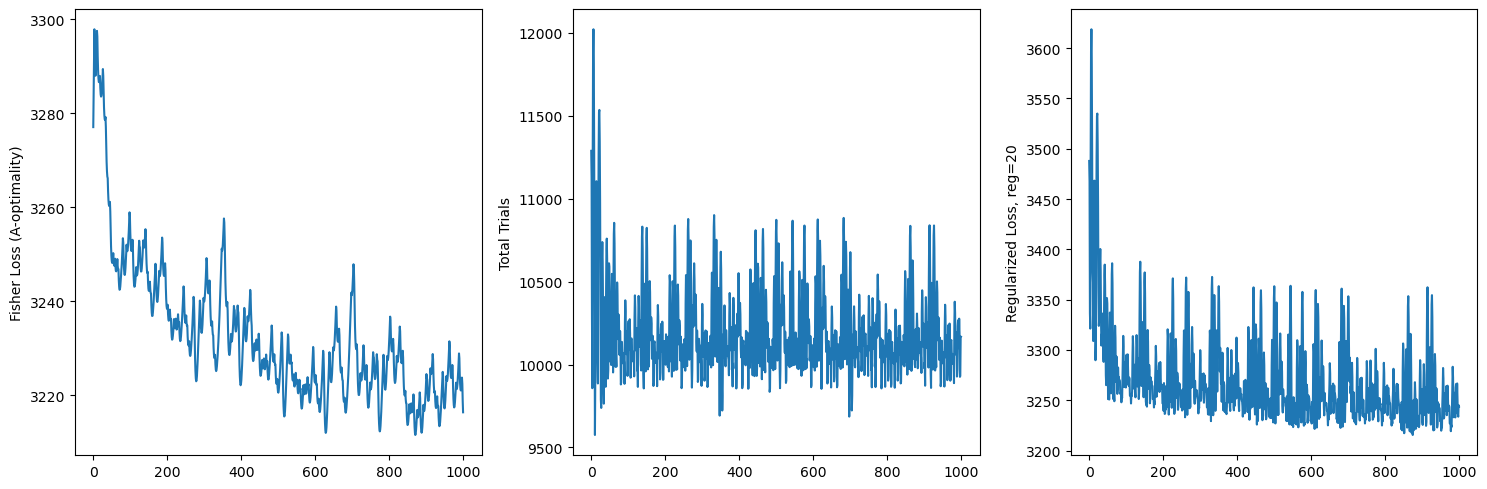

0.014409450584308533 0.03380005933387758


In [12]:
total_budget = 20000
num_iters = 2
budget = int(total_budget / num_iters)
reg = 20 # 50
T_step_size = 0.1 # 0.05, 0.01
T_n_steps = 1000    # 5000
init_trials = 5
ms = [1]
disambiguate = True
verbose = True
R2_cutoff = 0

T_prev = np.zeros_like(trials_neg, dtype=float)
T_prev[:, 12::3] = init_trials
T_prev[bad_inds, :] = 0
T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true, T_prev, NUM_THREADS=24)
probs_empirical_uniform = deepcopy(probs_empirical)

performances = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    if iter_cnt == 0:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps_neg,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)

        performance = get_performance_array(params_true, probs_curr, probs_true)
        performance_uniform = performance

        w_inits_array_uniform = deepcopy(w_inits_array)
        
    else:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps_neg,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        t_final=t_final,
                                        w_inits_array=w_inits_array,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)
        
        performance = get_performance_array(params_true, probs_curr, probs_true)

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps_neg, T_prev_uniform, w_inits_array_uniform,
                                                            disambiguate=disambiguate)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        w_inits_array_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        probs_curr_uniform = np.zeros(probs_empirical_uniform.shape)

        cnt = 0
        for i in range(len(probs_empirical_uniform)):
            for j in range(len(probs_empirical_uniform[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps_neg[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

        performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true)
    
    print(performance, performance_uniform)
    
    performances.append(performance)
    performances_uniform.append(performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))

    iter_cnt += 1

    if iter_cnt > num_iters:
        break

    p_new = sample_spikes_array(probs_true, T_new, NUM_THREADS=24)
    p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
    T_tmp = T_new + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp
    
    T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    T_new_uniform[:, :12] = 0
    T_new_uniform[bad_inds, :] = 0
    p_new_uniform = sample_spikes_array(probs_true, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

In [13]:
baseline_trials = 20
T_prev_baseline = np.ones_like(trials_neg, dtype=float) * baseline_trials

probs_empirical_baseline = sample_spikes_array(probs_true, T_prev_baseline, NUM_THREADS=24)

w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_empirical_baseline, amps_neg, T_prev_baseline, w_inits_array_baseline,
                                                    disambiguate=disambiguate)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
probs_curr_baseline = np.zeros(probs_empirical_baseline.shape)

cnt = 0
for i in range(len(probs_empirical_baseline)):
    for j in range(len(probs_empirical_baseline[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]
        w_inits_array_baseline[i][j] = mp_output_baseline[cnt][1]
        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

performance_baseline = get_performance_array(params_true, probs_curr_baseline, probs_true)

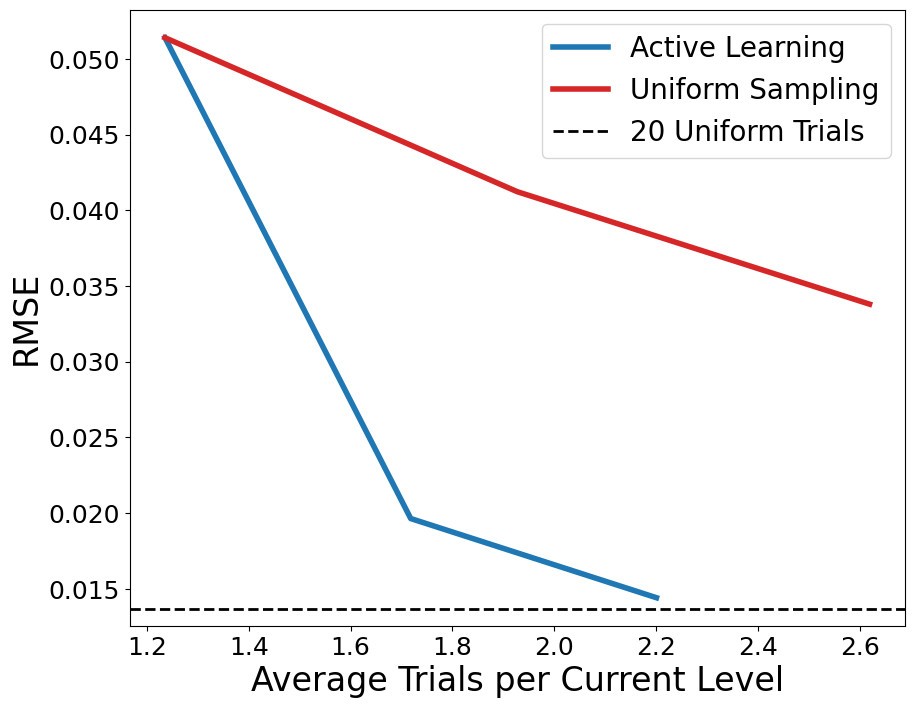

In [14]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(num_samples)/trials_neg.shape[0]/trials_neg.shape[1], performances, linewidth=4, c='tab:blue', label='Active Learning')
plt.plot(np.array(num_samples_uniform)/trials_neg.shape[0]/trials_neg.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Uniform Sampling')

plt.axhline(performance_baseline, c='k', linestyle='--', linewidth=2, label='20 Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds = np.where(T_prev[j] > 0)[0]

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j][sampled_inds], probs_empirical[i][j][sampled_inds])
            plt.plot(amps_neg[j], probs_curr[i][j])
            plt.plot(amps_neg[j], probs_true[i][j])
            plt.show()
            input()

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds_uniform = np.where(T_prev_uniform[j] > 0)[0]

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j][sampled_inds_uniform], probs_empirical_uniform[i][j][sampled_inds_uniform])
            plt.plot(amps_neg[j], probs_curr_uniform[i][j])
            plt.plot(amps_neg[j], probs_true[i][j])
            plt.show()
            input()

# New labview

In [ ]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2022-11-28-1"
wnoise = "data010"
# blanked_probs = 12
spont_limit = 0.25
min_inds = 3

estim_neg = "data009"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_neg))

# all_probs_neg[:, :, :blanked_probs] = np.zeros(all_probs_neg[:, :, :blanked_probs].shape)

clean_inds_array = np.full((all_probs_neg.shape[0], all_probs_neg.shape[1]), 
                            None, dtype=object)

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if np.count_nonzero(all_probs_neg[i][j] >= spont_limit) >= min_inds:
            print(cells[i], j+1)

            clean_inds = np.where(~np.isnan(all_probs_neg[i][j]))[0]
            clean_inds_array[i][j] = clean_inds

            
            all_probs_neg[i][j][clean_inds] = fitting.disambiguate_sigmoid(all_probs_neg[i][j][clean_inds],
                                                                            spont_limit=spont_limit, noise_limit=0.1)
        
all_probs_neg = all_probs_neg[:, :, ::-1]
trials_neg = trials_neg[:, ::-1]
amps_neg = amps_neg[:, ::-1, :]

In [ ]:
estim_pos = "data003"

outpath = os.path.join(GSORT_BASE, dataset, estim_pos, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_pos)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_pos = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_pos = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_pos = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_pos))

# all_probs_pos[:, :, :blanked_probs] = np.zeros(all_probs_pos[:, :, :blanked_probs].shape)

for i in range(len(all_probs_pos)):
    for j in range(len(all_probs_pos[i])):
        all_probs_pos[i][j] = fitting.disambiguate_sigmoid(all_probs_pos[i][j], spont_limit=0.3, noise_limit=0.1)

In [ ]:
all_probs = all_probs_neg#np.concatenate((all_probs_neg, all_probs_pos), axis=2)
trials = trials_neg#np.concatenate((trials_neg, trials_pos), axis=1)
amps = amps_neg#np.concatenate((amps_neg, amps_pos), axis=1)

In [ ]:
ms = [1]

w_inits_array = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [ ]:
input_list = fitting.generate_input_list(all_probs, amps, trials, w_inits_array,
                                            pass_inds=clean_inds_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [ ]:
params_true = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
inits = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
R2s = np.zeros((all_probs.shape[0], all_probs.shape[1]))
probs_true = np.zeros(all_probs.shape)

cnt = 0
for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        R2s[i][j] = mp_output[cnt][2]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps[j], has_constant='add'), 
                                params_true[i][j])
        

        cnt += 1

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(params_true[i][j], R2s[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps[j].flatten(), all_probs[i][j])
            plt.plot(amps[j].flatten(), probs_true[i][j])
            plt.show()
            input()

In [ ]:
EI_cutoff = 0

vstim_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vstim_datarun = wnoise[-7:]
vcd = vl.load_vision_data(vstim_datapath, vstim_datarun,
                          include_neurons=True,
                          include_ei=True,
                          include_params=True,
                          include_noise=True)

above_thr_inds = []
for n in vcd.get_cell_ids():
    cell_type = vcd.get_cell_type_for_cell(n).lower()
    if 'parasol' in cell_type or 'midget' in cell_type:
        _, EI = mutils.get_collapsed_ei_thr(vcd, n, 0)
        above_thr = np.where(EI > EI_cutoff)[0]
        if len(above_thr) > 0:
            above_thr_inds.append(above_thr)

above_thr_all = np.unique(np.concatenate(above_thr_inds))
bad_inds = np.setdiff1d(np.arange(len(trials), dtype=int), above_thr_all).astype(int)

In [ ]:
total_budget = 20000
num_iters = 2
budget = int(total_budget / num_iters)
reg = 20 # 50
T_step_size = 0.1 # 0.05, 0.01
T_n_steps = 2000    # 5000
init_trials = 5
ms = [1]
disambiguate = True
verbose = True
R2_cutoff = 0

T_prev = np.zeros_like(trials, dtype=float)
T_prev[:, ::4] = init_trials
T_prev[bad_inds, :] = 0
T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true, T_prev, NUM_THREADS=24)
probs_empirical_uniform = deepcopy(probs_empirical)

performances = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    # reg = reg * (0.8 ** (iter_cnt))  # UNTESTED
    if iter_cnt == 0:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)

        performance = get_performance_array(params_true, probs_curr, probs_true)
        performance_uniform = performance

        w_inits_array_uniform = deepcopy(w_inits_array)
        
    else:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        t_final=t_final,
                                        w_inits_array=w_inits_array,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)
        
        performance = get_performance_array(params_true, probs_curr, probs_true)

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps, T_prev_uniform, w_inits_array_uniform,
                                                            disambiguate=disambiguate)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        w_inits_array_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        probs_curr_uniform = np.zeros(probs_empirical_uniform.shape)

        cnt = 0
        for i in range(len(probs_empirical_uniform)):
            for j in range(len(probs_empirical_uniform[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

        performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true)
    
    print(performance, performance_uniform)
    
    performances.append(performance)
    performances_uniform.append(performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))

    iter_cnt += 1

    if iter_cnt > num_iters:
        break

    p_new = sample_spikes_array(probs_true, T_new, NUM_THREADS=24)
    p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
    T_tmp = T_new + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp
    
    T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    T_new_uniform[bad_inds, :] = 0
    p_new_uniform = sample_spikes_array(probs_true, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

In [ ]:
baseline_trials = 20
T_prev_baseline = np.ones_like(trials, dtype=float) * baseline_trials

probs_empirical_baseline = sample_spikes_array(probs_true, T_prev_baseline, NUM_THREADS=24)

w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_empirical_baseline, amps, T_prev_baseline, w_inits_array_baseline,
                                                    disambiguate=disambiguate)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
probs_curr_baseline = np.zeros(probs_empirical_baseline.shape)

cnt = 0
for i in range(len(probs_empirical_baseline)):
    for j in range(len(probs_empirical_baseline[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]
        w_inits_array_baseline[i][j] = mp_output_baseline[cnt][1]
        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

performance_baseline = get_performance_array(params_true, probs_curr_baseline, probs_true)

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(num_samples)/trials.shape[0]/trials.shape[1], performances, linewidth=4, c='tab:blue', label='Active Learning')
plt.plot(np.array(num_samples_uniform)/trials.shape[0]/trials.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Uniform Sampling')

plt.axhline(performance_baseline, c='k', linestyle='--', linewidth=2, label='20 Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds = np.where(T_prev[j] > 0)[0]

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 4.4)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps[j][sampled_inds], probs_empirical[i][j][sampled_inds])
            plt.plot(amps[j], probs_curr[i][j])
            plt.plot(amps[j], probs_true[i][j])
            plt.show()
            input()

In [ ]:
amps[1][10:]